# Przygotowanie 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install shap
! pip install SAlib
! pip install ReliefF
! pip install seaborn
#! pip install sklearn-relief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 758 kB 5.0 MB/s 
     |████████████████████████████████| 132 kB 69.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.6 MB/s 
  Created wheel for ReliefF: filename=ReliefF-0.1.2-py3-none-any.whl size=6318 sha256=802f70e1761e906ae806302d7d5c702f6b250dce028f26d6ab3cd0fa365c2558
  Stored in directory: /root/.cache/pip/wheels/d8/90/ef/7691706c1c418d2c266a0b3b06371900f4b86e74223912c563
Successfully built ReliefF
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# importy ogólne
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython.display import clear_output
from IPython.display import display, HTML
import pickle

# importy do modeli klasyfikacji
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# importy do sieci neuronowych keras
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# insterpretacja istotności
import shap
from ReliefF import ReliefF

# Analiza danych

In [4]:
seeds_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/seeds_dataset.txt', sep='\s+')
seeds_data.columns = ['area', 'perimeter', 'compactness', 'k_length', 'k_width', 'asymmetry_coef', 'g_length', 'type']
x_columns = ['area', 'perimeter', 'compactness', 'k_length', 'k_width', 'asymmetry_coef', 'g_length' ]
y_columns = ['type']
class_names = [ 'Kama', 'Rosa', 'Canadian']
class_map = {  1: 'Kama', 2: 'Rosa', 3: 'Canadian'}
mapped_seeds_data = seeds_data.copy()
mapped_seeds_data['type'] = mapped_seeds_data['type'].apply( lambda x: class_map[x] )
print( seeds_data.info() )
print( seeds_data.head() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            209 non-null    float64
 1   perimeter       209 non-null    float64
 2   compactness     209 non-null    float64
 3   k_length        209 non-null    float64
 4   k_width         209 non-null    float64
 5   asymmetry_coef  209 non-null    float64
 6   g_length        209 non-null    float64
 7   type            209 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB
None
    area  perimeter  compactness  k_length  k_width  asymmetry_coef  g_length  \
0  14.88      14.57       0.8811     5.554    3.333           1.018     4.956   
1  14.29      14.09       0.9050     5.291    3.337           2.699     4.825   
2  13.84      13.94       0.8955     5.324    3.379           2.259     4.805   
3  16.14      14.99       0.9034     5.658    3.562           1.35

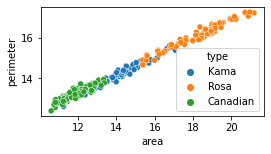

In [13]:
plt.figure( figsize=(4,2) )
sns.scatterplot(data=mapped_seeds_data, x='area', y='perimeter', hue='type')

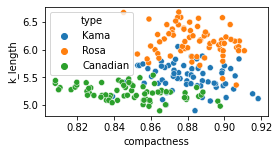

In [14]:
plt.figure( figsize=(4,2) )
sns.scatterplot(data=mapped_seeds_data, x='compactness', y='k_length', hue='type')

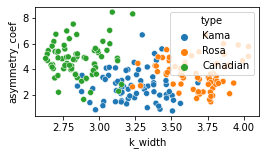

In [15]:
plt.figure( figsize=(4,2) )
sns.scatterplot(data=mapped_seeds_data, x='k_width', y='asymmetry_coef', hue='type')

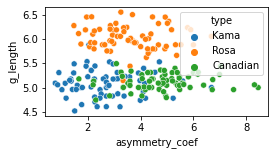

In [16]:
plt.figure( figsize=(4,2) )
sns.scatterplot(data=mapped_seeds_data, x='asymmetry_coef', y='g_length', hue='type')

In [17]:
x_train, x_test, y_train, y_test = train_test_split(seeds_data.drop('type', axis=1), seeds_data['type'], test_size=0.3, random_state=101) 
cols = x_train.columns.values

scaler = MinMaxScaler()
scaler.fit(x_train)
y_train = y_train.reset_index().drop('index', axis=1)
y_test = y_test.reset_index().drop('index', axis=1)
x_train = pd.DataFrame(scaler.transform(x_train), columns=cols)
x_test = pd.DataFrame(scaler.transform(x_test), columns=cols)

# Model drzewa decyzyjnego

In [ ]:
dtree_model = DecisionTreeClassifier(max_depth=2)
dtree_model.fit(x_train, y_train)

y_pred = dtree_model.predict(x_test)

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_test, y_pred) )
print( dtree_model.get_depth() )

              precision    recall  f1-score   support

           1       1.00      0.81      0.89        26
           2       1.00      1.00      1.00        11
           3       0.84      1.00      0.91        26

    accuracy                           0.92        63
   macro avg       0.95      0.94      0.94        63
weighted avg       0.93      0.92      0.92        63

[[21  0  5]
 [ 0 11  0]
 [ 0  0 26]]
2


In [ ]:
pickle.dump(dtree_model, open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/QMNIST_DTREE.sav', 'wb') )

# Model randomowych lasów

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

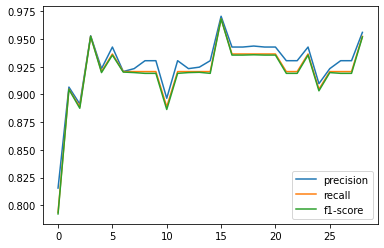

In [ ]:
estimators = [ i*2 for i in range(1, 30) ]
class_metrics = {'precision': [], 'recall': [], 'f1-score': []}

for n_est in estimators:
  rforest = RandomForestClassifier(n_estimators=n_est)
  rforest.fit(x_train, y_train.values.ravel())

  y_pred = rforest.predict(x_test)
  report = pd.DataFrame( classification_report(y_test, y_pred, output_dict=True) ).transpose()
  class_metrics['precision'].append(report['precision'].loc['weighted avg'])
  class_metrics['recall'].append(report['recall'].loc['weighted avg'])
  class_metrics['f1-score'].append(report['f1-score'].loc['weighted avg'])

class_metrics = pd.DataFrame(class_metrics)
class_metrics.plot()

In [ ]:
rforest_model = RandomForestClassifier(n_estimators=15)
rforest_model.fit(x_train, y_train)

y_pred = rforest.predict(x_test)

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_test, y_pred) )

              precision    recall  f1-score   support

           1       1.00      0.88      0.94        26
           2       0.92      1.00      0.96        11
           3       0.93      1.00      0.96        26

    accuracy                           0.95        63
   macro avg       0.95      0.96      0.95        63
weighted avg       0.96      0.95      0.95        63

[[23  1  2]
 [ 0 11  0]
 [ 0  0 26]]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
pickle.dump(rforest_model, open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/QMNIST_RFOREST.sav', 'wb') )

# Model MLP

In [ ]:
mlp_y_train = pd.get_dummies( y_train['type'] )
mlp_y_test = pd.get_dummies(y_test['type'] )

mlp_model = Sequential()
mlp_model.add( Dense(18, input_dim=7, activation='relu') )
mlp_model.add( Dense(7, activation='relu') )
mlp_model.add( Dense(7, activation='relu') )
mlp_model.add( Dense(3, activation='softmax') )

mlp_model.compile(loss='categorical_crossentropy', optimizer='adam')

history = mlp_model.fit(x_train, mlp_y_train, batch_size=12, epochs=150, validation_data=[x_test, mlp_y_test], verbose=1)
# dla epochs>150 przeuczenie

Epoch 1/150
13/13 [==============================] - 1s 21ms/step - loss: 0.9969 - val_loss: 1.0813
Epoch 2/150
13/13 [==============================] - 0s 6ms/step - loss: 0.9636 - val_loss: 1.0577
Epoch 3/150
13/13 [==============================] - 0s 6ms/step - loss: 0.9327 - val_loss: 1.0378
Epoch 4/150
13/13 [==============================] - 0s 6ms/step - loss: 0.9051 - val_loss: 1.0145
Epoch 5/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8775 - val_loss: 0.9964
Epoch 6/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8510 - val_loss: 0.9794
Epoch 7/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8261 - val_loss: 0.9576
Epoch 8/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8029 - val_loss: 0.9428
Epoch 9/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7790 - val_loss: 0.9218
Epoch 10/150
13/13 [==============================] - 0s 6ms/step - loss: 0.7511 - val_loss: 0.8806
Epoch 11

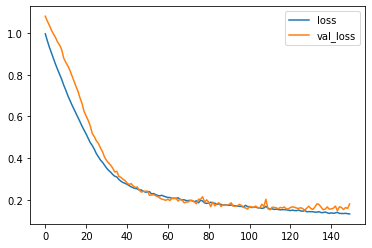

In [ ]:
pd.DataFrame( history.history ).plot()

In [ ]:
y_pred = mlp_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1) + 1

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_pred, y_test) )

2/2 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           1       0.95      0.77      0.85        26
           2       0.79      1.00      0.88        11
           3       0.89      0.96      0.93        26

    accuracy                           0.89        63
   macro avg       0.88      0.91      0.89        63
weighted avg       0.90      0.89      0.89        63

[[20  0  1]
 [ 3 11  0]
 [ 3  0 25]]


In [ ]:
mlp_model.save('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/SEED_MLP')

# Model SVM

In [ ]:
grid_params = { 'C': [0.1, 1, 10, 100, 1000, 10000, 100000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['poly', 'linear', 'rbf']}
grid = GridSearchCV( SVC(), param_grid=grid_params, verbose=1 )

grid.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 105 candidates, totalling 525 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000, 100000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly', 'linear', 'rbf']},
             verbose=1)

In [ ]:
print( grid.best_params_ )

y_pred = grid.predict(x_test)

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_test, y_pred) )

{'C': 1000, 'gamma': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           1       1.00      0.88      0.94        26
           2       1.00      1.00      1.00        11
           3       0.90      1.00      0.95        26

    accuracy                           0.95        63
   macro avg       0.97      0.96      0.96        63
weighted avg       0.96      0.95      0.95        63

[[23  0  3]
 [ 0 11  0]
 [ 0  0 26]]


In [ ]:
svm_model = SVC(C=1000, gamma=1, kernel='poly', probability=True)
svm_model.fit(x_train, y_train.values.ravel())

y_pred = svm_model.predict(x_test)

print( classification_report(y_test, y_pred) )
print( confusion_matrix(y_test, y_pred) )

              precision    recall  f1-score   support

           1       0.96      0.96      0.96        26
           2       1.00      1.00      1.00        11
           3       0.96      0.96      0.96        26

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63

[[25  0  1]
 [ 0 11  0]
 [ 1  0 25]]


In [ ]:
pickle.dump(svm_model, open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/QMNIST_SVM.sav', 'wb') )

# Analiza istotności 

In [ ]:
import shap
import tensorflow as tf
from SALib.analyze import morris
from SALib.analyze import sobol
from SALib.sample import saltelli
from SALib.sample import sobol as sob
import SALib

# Do analizy shap
Ksamples = shap.sample(x_train, 100)
pickle.dump(Ksamples, open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/Ksamples.sav', 'wb'))
Ksamples = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/Ksamples.sav', 'rb'))

# Do analizay wrazliwosci
problem = {
    'num_vars' : 7,
    'names' : x_columns,
    'bounds' : [
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]
    ]
}

param_values = saltelli.sample(problem, 1024)
pickle.dump(param_values, open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/param_values.sav', 'wb'))
param_values = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/param_values.sav', 'rb') )

# wyliczenie efektów elementarnym zgodnie z dokumentacją SALib dla każdej klasy oddzielnie
# efekty są potęgowane i sumowane 
# na koniec wybieranu jest max z efektów dla danego atrybutu z 3 klas 
def get_morris_features(X, Y, problem):
  r_sum_elementary_effects = []
  for g_class in range( Y.shape[1] ):
    morris._define_problem_with_groups(problem)

    delta = morris._compute_delta(4)

    num_vars = problem["num_vars"]
    groups = morris._check_groups(problem)
    if not groups:
        number_of_groups = num_vars
    else:
        groups, unique_group_names = morris.compute_groups_matrix(groups)
        number_of_groups = len(set(unique_group_names))

    num_trajectories = int(Y[:, g_class].size / (number_of_groups + 1))
    trajectory_size = int(Y[:, g_class].size / num_trajectories)

    elementary_effects = morris._compute_elementary_effects(X, Y[:, g_class], trajectory_size, delta)
    P = elementary_effects.shape[-1]
    elementary_effects = np.sqrt(np.sum(np.power(elementary_effects, 2), axis=1) / P)
    r_sum_elementary_effects.append( elementary_effects )
    
  r_sum_elementary_effects = np.max(np.array(r_sum_elementary_effects), axis=0)
  print( r_sum_elementary_effects.shape )

  features_morris = pd.DataFrame( r_sum_elementary_effects, columns=['waga'], index=problem['names'] )
  features_morris.sort_values('waga', ascending=True, inplace=True)
  return features_morris


def Gini(proba) -> np.array:
  res = np.ones( [len(proba), ] )
  res = res - np.power( np.array(proba), 2 ).sum(axis=1).reshape(-1,)
  return res

dtree_models = [ x for x in range(len(x_train.columns.values)) ]

# funkcja resetująca wagi modelu mlp na losowe wartości
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))


def evaluate_models(features, models, params_for_model_fitting = {}, model_builder=None, amounts=10) -> None:
  '''
  funkcja mająca na celu wytrenować kolejny model z listy
  używając co iteracje nowego modelu i pomniejszonej liczby atrybutów.
  Na sam koniec wyrysowując dopasowanie modelu i 
  wypisując sqrt(mse) oraz mae
  '''

  # zbiór danych do odrzucania najmniej znaczącyh
  relief_x_train = x_train
  relief_x_test = x_test
  model_avg_scores = []
  history = []

  for i, model in enumerate(models):
    # usunięcie kolejnego atrybutu
    if( i > 0 ):
      relief_x_train = relief_x_train.drop( features.index[i-1], axis=1 )
      relief_x_test = relief_x_test.drop( features.index[i-1], axis=1 )

    if( model_builder ):
      _y_train = y_train
      _y_test = y_test
    else:
      _y_train = pd.get_dummies(y_train['type'])
      _y_test = pd.get_dummies(y_test['type'] )

    # wytrenowanie modelu 10-krotnie i zebranie wartości błędu
    scores = []
    for dummie in range(amounts):
      if (model_builder):
        model = model_builder()
        model.fit(relief_x_train, _y_train.values.ravel())
        y_pred = model.predict(relief_x_test)
      else:
        reinitialize(model)
        his = model.fit(relief_x_train, _y_train, **params_for_model_fitting)
        y_pred = model.predict(relief_x_test)
        y_pred = (y_pred >= 0.5) * 1

      score = pd.DataFrame( classification_report(_y_test, y_pred, output_dict=True) ).drop('weighted avg', axis=1).drop('support', axis=0)
      #if( not model_builder and (score.loc['f1-score'][0] == 0.0 or score.loc['f1-score'][0] == 0.0) ):
        #history.append(his)

      scores.append( score )
      
    model_avg_scores.append( [sum(scores)/ len(scores), len(relief_x_train.columns.values)] )


    # napis z metrykami
  print( "########## AVG SCORES ########")
  for avg_s in model_avg_scores:
    print( f'ilość atrybutów: {avg_s[1]}')
    print( avg_s[0] )
    print()
  print( "########## AVG SCORES ########")

  f1_score = [ x[0].loc['f1-score']['macro avg'] for x in model_avg_scores ]
  attr = range(len(features), 0, -1)
  plt.figure( figsize=(10, 5) )
  plt.xlim(max(attr), min(attr))
  plt.title('Wykres metryki f1-score od ilości atrybutów')
  plt.xlabel('Liczba atrybutów')
  plt.ylabel('f1-score')
  sns.lineplot(x=attr, y=f1_score, marker='o', linestyle='--')
  # czasem model mlp zatrzymuje sie na loss=0.5
  

# klasy zwracające instancje modelów 
class dtree_builder:
  def __call__(self):
    return DecisionTreeClassifier( max_depth=2 )

class rforest_builder:
  def __call__(self):
    return RandomForestClassifier(n_estimators=15)

class svm_builder:
  def __call__(self):
    return SVC(C=1000, gamma=1, kernel='poly', probability=True)

def create_mlp(in_dim):
  mlp_model = Sequential()
  mlp_model.add( Dense(18, input_dim=in_dim, activation='relu') )
  mlp_model.add( Dense(7, activation='relu') )
  mlp_model.add( Dense(7, activation='relu') )
  mlp_model.add( Dense(3, activation='softmax') )
  mlp_model.compile(loss='categorical_crossentropy', optimizer='adam')
  return mlp_model

early_stop = EarlyStopping(monitor='loss', patience=5, mode='min')
mlp_params = {'verbose':0, 'epochs':300, 'batch_size':12, 'callbacks':[early_stop] }

attributes_dict = {}
for i, attr in enumerate(x_train.columns.values):
  attributes_dict[attr] = str(i)
  print(f'{attr} : {i}')

`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`


area : 0
perimeter : 1
compactness : 2
k_length : 3
k_width : 4
asymmetry_coef : 5
g_length : 6


# 0. Analiza przy pomocy ReliefF

Text(0.5, 0, 'numer atrybutu')

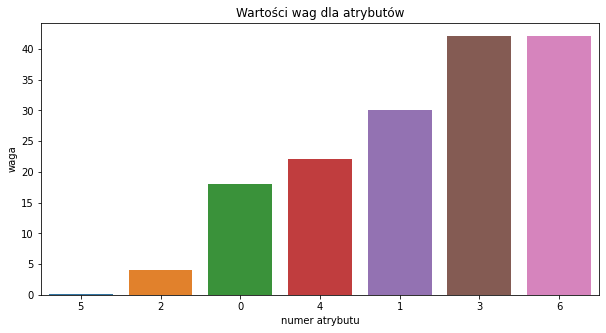

In [ ]:
rel = ReliefF(n_neighbors=20)
rel.fit( X=x_train.values, y=y_train.values.ravel())
features = rel.feature_scores

features = features + np.abs(min( features ) - 0.1)
features_relief = pd.DataFrame(features.reshape(-1, 1), index=x_columns, columns=['waga'])
features_relief.sort_values('waga', ascending=True, inplace=True)

plt.figure( figsize=(10, 5) )
x_nums = [ attributes_dict[col] for col in features_relief.index ]
sns.barplot(data=features_relief, x=x_nums, y='waga')
plt.title('Wartości wag dla atrybutów')
plt.xlabel('numer atrybutu')

Model Drzewa Decyzyjnego

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 6
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 5
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 4
                  1    2         3  accuracy  macro avg
precision  0.954545  1.0  0.833333  0.904762   0.929293
recall     0.807692  1.0  0.961538  0.904762   0.923077
f1-score   0.875000  1.0  0.892857  0.904762   0.9

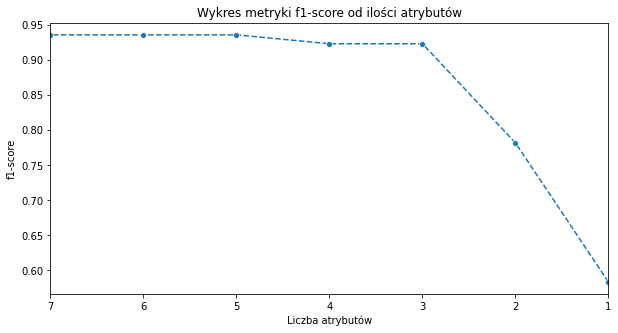

In [ ]:
evaluate_models(features_relief, dtree_models, model_builder=dtree_builder(), amounts=10)

Model Randomowych Lasów

########## AVG SCORES ########
ilość atrybutów: 7
                  1         2         3  accuracy  macro avg
precision  0.982592  0.876648  0.898594  0.922222   0.919278
recall     0.826923  1.000000  0.984615  0.922222   0.937179
f1-score   0.896983  0.933290  0.939453  0.922222   0.923242

ilość atrybutów: 6
                  1         2         3  accuracy  macro avg
precision  0.963167  0.917949  0.906484  0.928571   0.929200
recall     0.861538  1.000000  0.965385  0.928571   0.942308
f1-score   0.908754  0.956884  0.934640  0.928571   0.933426

ilość atrybutów: 5
                  1         2         3  accuracy  macro avg
precision  0.947960  0.951282  0.911901  0.931746   0.937048
recall     0.884615  1.000000  0.950000  0.931746   0.944872
f1-score   0.914362  0.974275  0.930160  0.931746   0.939599

ilość atrybutów: 4
                  1         2         3  accuracy  macro avg
precision  0.959114  0.975000  0.902350  0.936508   0.945488
recall     0.884615  1.000000  0.961

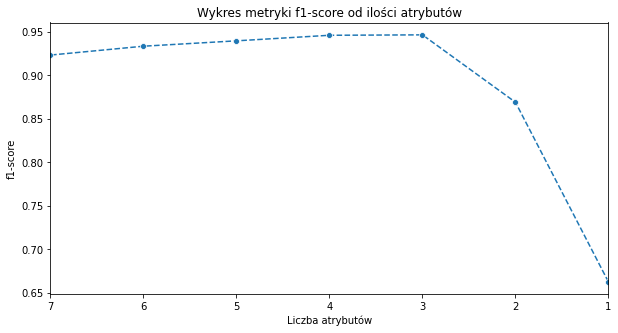

In [ ]:
rforest_models = [ x for x in range(len(x_train.columns.values)) ]
evaluate_models(features_relief, rforest_models, model_builder=rforest_builder(), amounts=10)

Model MLP

2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 4ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 4ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 4ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step
########## AVG SCORES ########
ilość atrybutów: 7
                  0         1         2  micro avg  macro avg  samples avg
precision  0.960532  0.840989  0.927208   0.919048   0.909576     0.919048
recall     0.838462  1.000000  0.965385   0.919048   0.934615     0.919048
f1-score   0.894476  0.911535  0.945622   0.919048   0.917211     0.919048

ilość atrybutów: 6
                  0         1         2  micro avg  macro avg  samples avg
precision  0.946838  0.922727  0.859823   0.901587   0.909796     0.901587
recall     0.807692  0.972727  0.965385   0.901587   0.915268     0.901587
f1-score   0.871395  0.946640  0.909405   0.901587   0.909147     0.901587

ilość atrybutów: 5
                  0         1         2  micro avg  macro avg  samples avg
precision  0.982016  0.897436  0.898645   0.926984   0.926032     0.926984
recall     0.838462  0.990909  0.988462   0.926984   0.939277     0.926984
f1-score   0.904230  0.940942  0.9

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


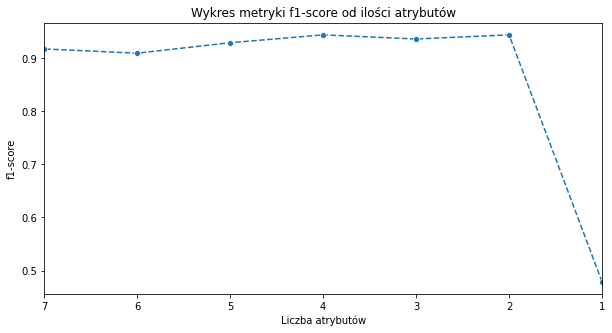

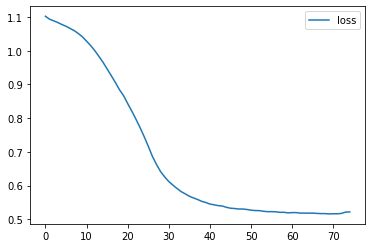

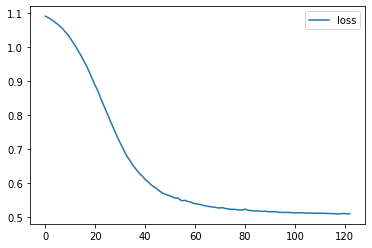

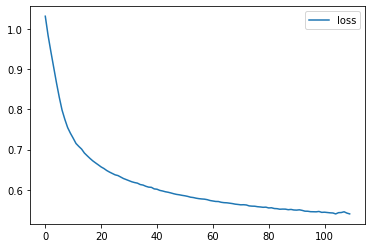

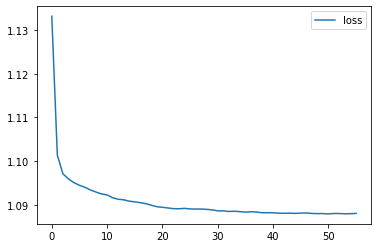

In [ ]:
mlp_models = [ create_mlp(len(x_train.columns.values)-i) for i in range(len(x_train.columns.values)) ]
evaluate_models(features_relief, mlp_models, mlp_params, amounts=10)

Model SVM

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  0.961538  1.0  0.961538  0.968254   0.974359
recall     0.961538  1.0  0.961538  0.968254   0.974359
f1-score   0.961538  1.0  0.961538  0.968254   0.974359

ilość atrybutów: 6
                  1         2         3  accuracy  macro avg
precision  0.958333  1.000000  0.896552  0.936508   0.951628
recall     0.884615  0.909091  1.000000  0.936508   0.931235
f1-score   0.920000  0.952381  0.945455  0.936508   0.939278

ilość atrybutów: 5
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.866667  0.936508   0.955556
recall     0.846154  1.0  1.000000  0.936508   0.948718
f1-score   0.916667  1.0  0.928571  0.936508   0.948413

ilość atrybutów: 4
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.866667  0.936508   0.955556
recall     0.846154  1.0  1.000000  0.936508   0.948718
f1-score   0.916667  1.0  0.92

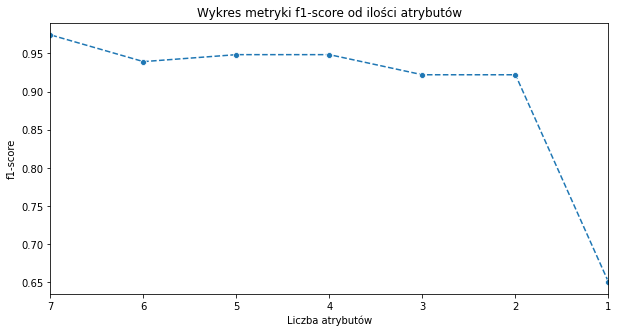

In [ ]:
svm_models = [ x for x in range(len(x_train.columns.values)) ]
evaluate_models(features_relief, svm_models, model_builder=svm_builder(), amounts=1)

# 1. Drzewo decyzyjne

Shap

In [ ]:
dtree_model = pickle.load( open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/QMNIST_DTREE.sav', 'rb') )

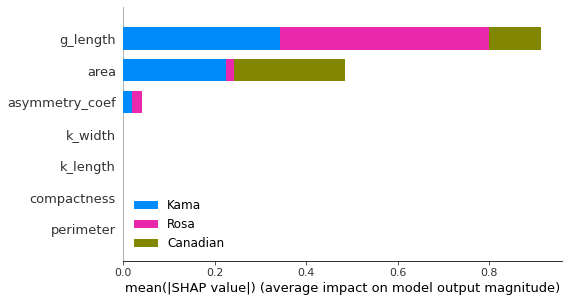

In [ ]:
dtree_shap_values = shap.TreeExplainer(dtree_model, Ksamples).shap_values(Ksamples)
shap.summary_plot(dtree_shap_values, Ksamples, feature_names=x_columns, class_names=class_names)

In [ ]:
vals = np.array(dtree_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )

                     waga
name                     
perimeter        0.000000
compactness      0.000000
k_length         0.000000
k_width          0.000000
asymmetry_coef   1.386667
area            16.127799
g_length        30.408953


Text(0.5, 0, 'numer atrybutu')

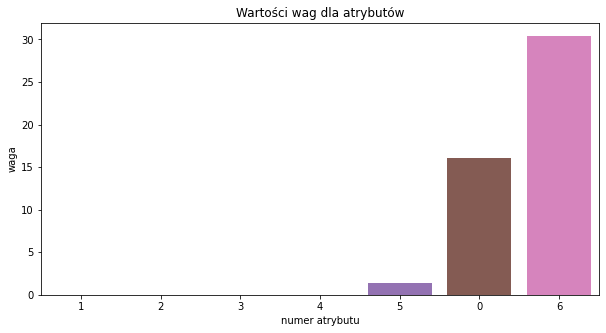

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 6
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 5
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 4
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.9

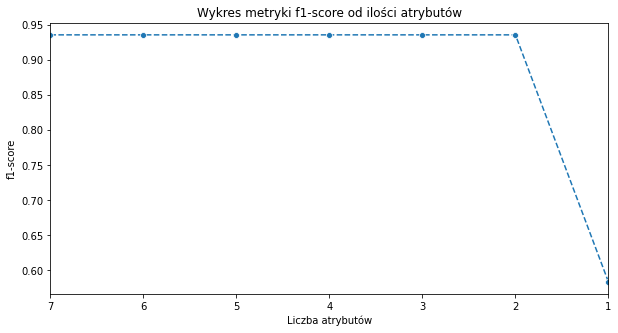

In [ ]:
evaluate_models(features_shap, dtree_models, model_builder=dtree_builder(), amounts=10)

Morris

In [ ]:
Y = dtree_model.predict_proba(param_values)
features_morris = get_morris_features(param_values, Y, problem)
print(features_morris)

(7,)
                    waga
area            0.895119
perimeter       1.001331
compactness     1.001333
k_length        1.001333
k_width         1.001513
asymmetry_coef  1.015051
g_length        1.389230


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Text(0.5, 0, 'numer atrybutu')

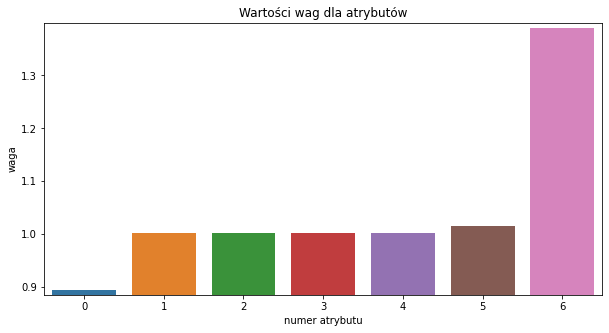

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_ylim([features_morris['waga'].min() - 0.01, features_morris['waga'].max() + 0.01])
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 6
                  1    2         3  accuracy  macro avg
precision  0.954545  1.0  0.833333  0.904762   0.929293
recall     0.807692  1.0  0.961538  0.904762   0.923077
f1-score   0.875000  1.0  0.892857  0.904762   0.922619

ilość atrybutów: 5
                  1    2         3  accuracy  macro avg
precision  0.655172  1.0  0.695652  0.730159   0.783608
recall     0.730769  1.0  0.615385  0.730159   0.782051
f1-score   0.690909  1.0  0.653061  0.730159   0.781323

ilość atrybutów: 4
                  1    2         3  accuracy  macro avg
precision  0.655172  1.0  0.695652  0.730159   0.783608
recall     0.730769  1.0  0.615385  0.730159   0.782051
f1-score   0.690909  1.0  0.653061  0.730159   0.7

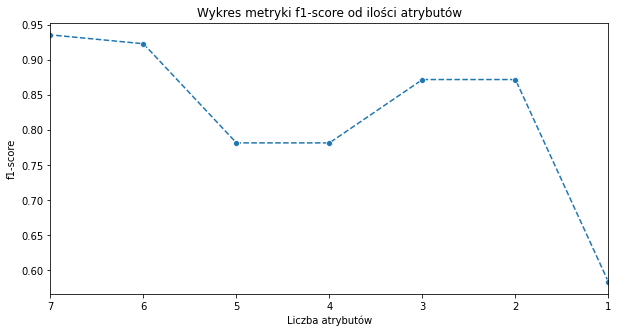

In [ ]:
evaluate_models(features_morris, dtree_models, model_builder=dtree_builder(), amounts=10)

Sobol

In [ ]:
features_sobol = []
for g_class in range(Y.shape[1]):
  features_sobol.append(sobol.analyze(problem, Y[:, g_class])['ST'] )

features_sobol = np.array(features_sobol)
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)

                    waga
perimeter       0.000000
compactness     0.000000
k_length        0.000000
k_width         0.000000
asymmetry_coef  0.022694
area            0.853463
g_length        0.990057


Text(0.5, 0, 'numer atrybutu')

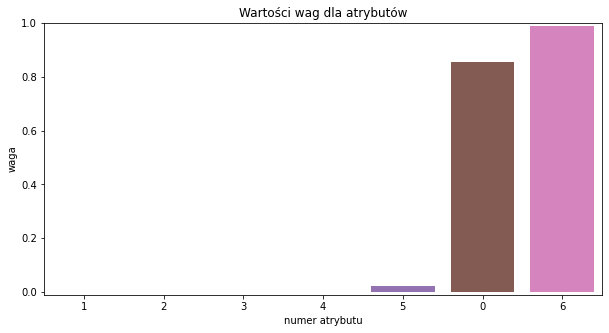

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
ax.set_ylim([features_sobol['waga'].min() - 0.01, features_sobol['waga'].max() + 0.01])
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 6
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 5
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.935299

ilość atrybutów: 4
                  1    2         3  accuracy  macro avg
precision  1.000000  1.0  0.838710  0.920635   0.946237
recall     0.807692  1.0  1.000000  0.920635   0.935897
f1-score   0.893617  1.0  0.912281  0.920635   0.9

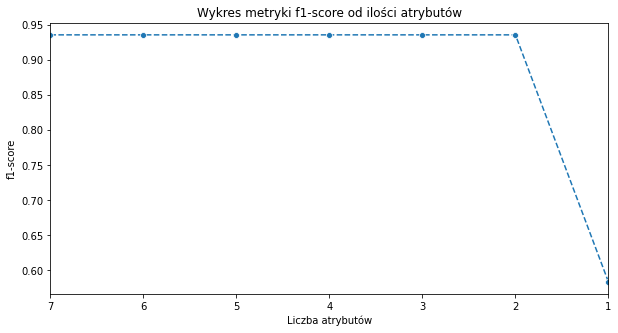

In [ ]:
evaluate_models(features_sobol, dtree_models, model_builder=dtree_builder(), amounts=10)

# 2. Randomowe lasy analiza shap

Shap

In [ ]:
rforest_model = pickle.load( open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/QMNIST_RFOREST.sav', 'rb') )

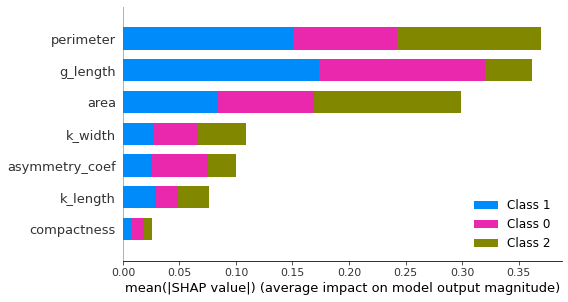

In [ ]:
rforest_shap_values = shap.TreeExplainer(rforest_model, Ksamples).shap_values(Ksamples)
shap.summary_plot(rforest_shap_values, Ksamples, feature_names=x_columns)

In [ ]:
vals = np.array(rforest_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)
x_columns = x_train.columns.values

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )

                     waga
name                     
compactness      0.848852
k_length         2.549378
asymmetry_coef   3.333259
k_width          3.635985
area             9.956230
g_length        12.062519
perimeter       12.320712


Text(0.5, 0, 'numer atrybutu')

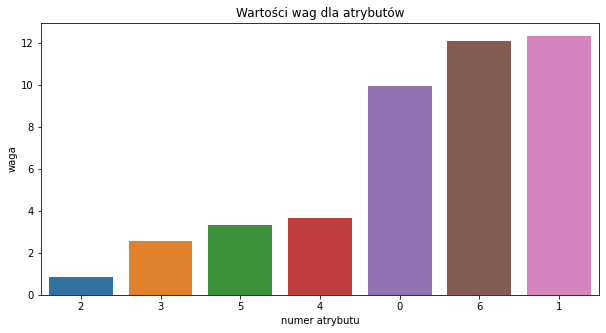

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1         2         3  accuracy  macro avg
precision  0.960477  0.856275  0.900356  0.911111   0.905703
recall     0.819231  0.990909  0.969231  0.911111   0.926457
f1-score   0.883286  0.917148  0.933088  0.911111   0.911174

ilość atrybutów: 6
                  1         2         3  accuracy  macro avg
precision  0.977668  0.876648  0.901294  0.922222   0.918537
recall     0.830769  1.000000  0.980769  0.922222   0.937179
f1-score   0.897649  0.933290  0.939181  0.922222   0.923373

ilość atrybutów: 5
                  1         2         3  accuracy  macro avg
precision  0.995238  0.869322  0.899507  0.925397   0.921356
recall     0.823077  1.000000  0.996154  0.925397   0.939744
f1-score   0.900786  0.929261  0.945320  0.925397   0.925122

ilość atrybutów: 4
                  1         2         3  accuracy  macro avg
precision  0.970986  0.927564  0.913919  0.936508   0.937489
recall     0.873077  1.000000  0.973

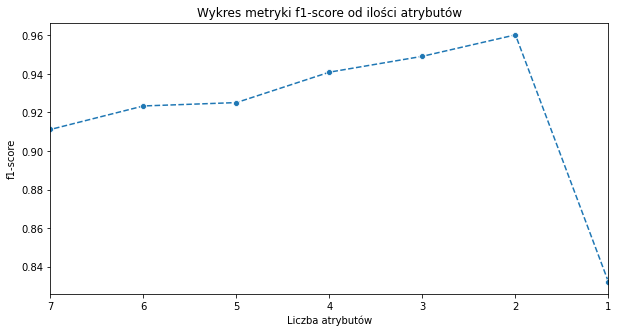

In [ ]:
rforest_models = [ x for x in range( len(features_shap) ) ]
evaluate_models(features_shap, rforest_models, model_builder=rforest_builder(), amounts=10)

Morris

In [ ]:
X = pd.DataFrame(param_values, columns=x_train.columns)
Y = rforest_model.predict_proba(X)

In [ ]:
features_morris = get_morris_features(X.values, Y, problem)
print( features_morris )

(7,)
                    waga
area            0.698665
g_length        0.783212
compactness     0.865675
asymmetry_coef  0.867551
k_width         0.868144
k_length        0.871157
perimeter       0.979690


Text(0.5, 0, 'numer atrybutu')

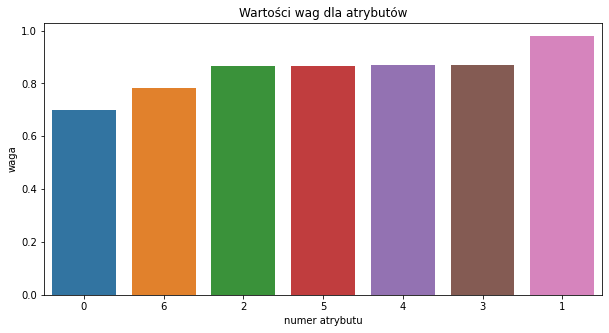

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1         2         3  accuracy  macro avg
precision  0.987121  0.909615  0.892981  0.928571   0.929906
recall     0.838462  1.000000  0.988462  0.928571   0.942308
f1-score   0.906434  0.952536  0.937955  0.928571   0.932308

ilość atrybutów: 6
                  1         2         3  accuracy  macro avg
precision  0.985429  0.903846  0.884061  0.922222   0.924445
recall     0.823077  1.000000  0.988462  0.922222   0.937179
f1-score   0.896107  0.948913  0.933169  0.922222   0.926063

ilość atrybutów: 5
                  1         2         3  accuracy  macro avg
precision  0.943738  0.799116  0.874447  0.879365   0.872434
recall     0.753846  0.981818  0.961538  0.879365   0.899068
f1-score   0.836886  0.879292  0.915746  0.879365   0.877308

ilość atrybutów: 4
                  1         2         3  accuracy  macro avg
precision  0.937031  0.792527  0.867209  0.873016   0.865589
recall     0.742308  0.990909  0.953

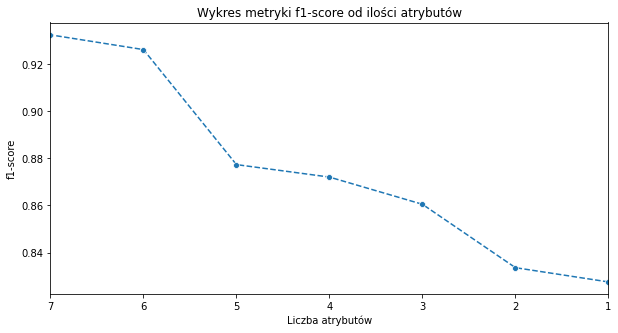

In [ ]:
evaluate_models(features_morris, rforest_models, model_builder=rforest_builder(), amounts=10)

Sobol

In [ ]:
features_sobol = []
for g_class in range(Y.shape[1]):
  features_sobol.append(sobol.analyze(problem, Y[:, g_class])['ST'] )

features_sobol = np.array(features_sobol)
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)

                    waga
compactness     0.028539
k_width         0.047166
k_length        0.050011
asymmetry_coef  0.147932
area            0.376235
perimeter       0.442633
g_length        0.590654


Text(0.5, 0, 'numer atrybutu')

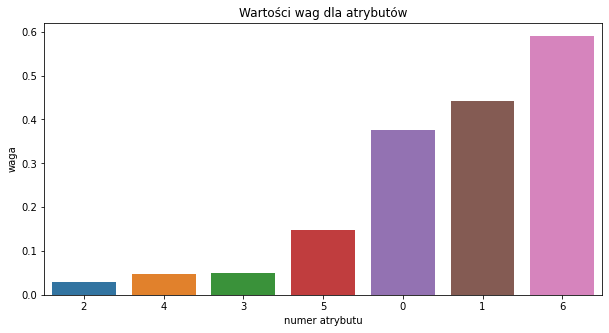

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1         2         3  accuracy  macro avg
precision  0.986759  0.902564  0.886388   0.92381   0.925237
recall     0.826923  1.000000  0.988462   0.92381   0.938462
f1-score   0.899438  0.948551  0.934536   0.92381   0.927508

ilość atrybutów: 6
                  1         2         3  accuracy  macro avg
precision  0.978909  0.907418  0.904601  0.930159   0.930309
recall     0.850000  1.000000  0.980769  0.930159   0.943590
f1-score   0.908843  0.949957  0.940928  0.930159   0.933242

ilość atrybutów: 5
                  1         2         3  accuracy  macro avg
precision  0.978426  0.926282  0.895146  0.930159   0.933285
recall     0.850000  1.000000  0.980769  0.930159   0.943590
f1-score   0.909048  0.961232  0.935816  0.930159   0.935366

ilość atrybutów: 4
                  1         2         3  accuracy  macro avg
precision  0.978063  0.906410  0.914231  0.934921   0.932901
recall     0.861538  1.000000  0.980

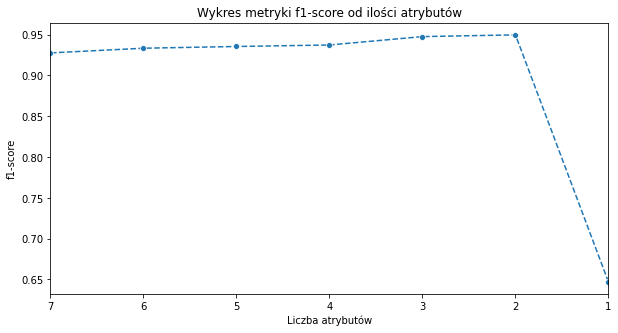

In [ ]:
evaluate_models(features_sobol, rforest_models, model_builder=rforest_builder(), amounts=10)

# 3. MLP analiza istotności shap

Shap

  0%|          | 0/100 [00:00<?, ?it/s]

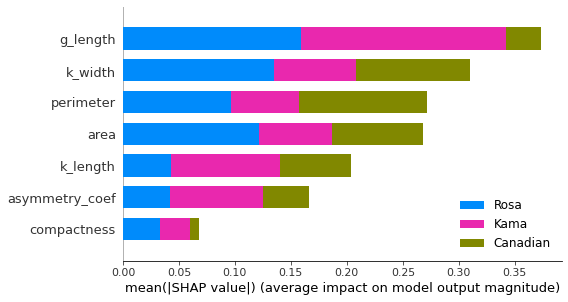

In [ ]:
mlp_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/SEED_MLP')
mlp_shap_values = shap.KernelExplainer(mlp_model, Ksamples).shap_values(Ksamples)
shap.summary_plot(mlp_shap_values, Ksamples, feature_names=x_columns, class_names=class_names)

In [ ]:
vals = np.array(mlp_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)
x_columns = x_train.columns.values

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )

                     waga
name                     
compactness      2.259950
asymmetry_coef   5.543786
k_length         6.788052
area             8.947951
perimeter        9.049251
k_width         10.331972
g_length        12.439112


Text(0.5, 0, 'numer atrybutu')

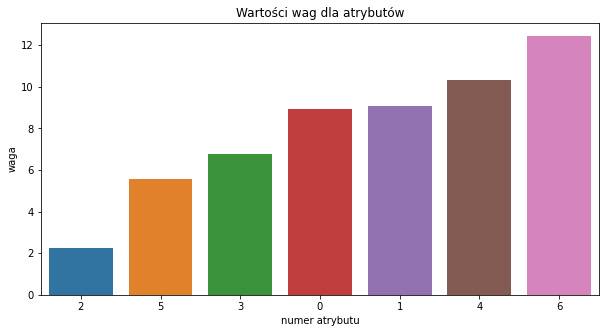

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

2/2 [==============================] - 0s 9ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 8ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 8ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step
########## AVG SCORES ########
ilość atrybutów: 7
                  0         1         2  micro avg  macro avg  samples avg
precision  0.964392  0.837942  0.913710   0.914132   0.905348     0.912698
recall     0.823077  0.990909  0.969231   0.912698   0.927739     0.912698
f1-score   0.887617  0.906111  0.940452   0.913410   0.911393     0.912698

ilość atrybutów: 6
                  0         1         2  micro avg  macro avg  samples avg
precision  0.954761  0.815806  0.926435   0.910829   0.899001     0.907937
recall     0.815385  1.000000  0.961538   0.907937   0.925641     0.907937
f1-score   0.878637  0.896550  0.943531   0.909371   0.906239     0.907937

ilość atrybutów: 5
                  0         1         2  micro avg  macro avg  samples avg
precision  0.882411  0.787179  0.816001   0.833333   0.828530     0.833333
recall     0.753846  0.881818  0.892308   0.833333   0.842657     0.833333
f1-score   0.812822  0.831522  0.8

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


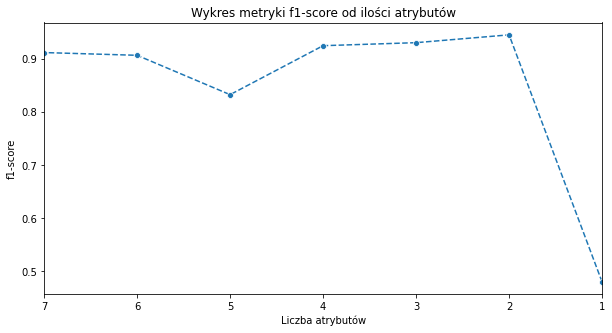

In [ ]:
mlp_models = []
for i in range( len(features_shap) ):
  mlp_models.append( create_mlp( len(features_shap)-i ) )

evaluate_models(features_shap, mlp_models, mlp_params, amounts=10)

Morris

In [ ]:
X = pd.DataFrame(param_values, columns=x_train.columns)
Y = mlp_model.predict(X)

2048/2048 [==============================] - 2s 1ms/step


In [ ]:
features_morris = get_morris_features(X.values, Y, problem)
print( features_morris )

(7,)
                    waga
g_length        0.893413
area            0.925548
k_length        1.037059
compactness     1.038739
asymmetry_coef  1.054700
perimeter       1.124897
k_width         1.201484


Text(0.5, 0, 'numer atrybutu')

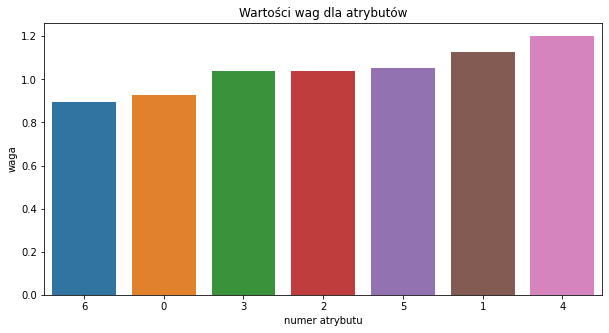

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

2/2 [==============================] - 0s 4ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 9ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 8ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 4ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 7ms/step
########## AVG SCORES ########
ilość atrybutów: 7
                  0         1         2  micro avg  macro avg  samples avg
precision  0.965222  0.868711  0.917571   0.921864   0.917168      0.91746
recall     0.834615  0.990909  0.969231   0.917460   0.931585      0.91746
f1-score   0.893382  0.922778  0.942254   0.919644   0.919471      0.91746

ilość atrybutów: 6
                  0         1         2  micro avg  macro avg  samples avg
precision  0.949811  0.805481  0.907052   0.898413   0.887448     0.898413
recall     0.796154  0.972727  0.969231   0.898413   0.912704     0.898413
f1-score   0.865522  0.878288  0.936883   0.898413   0.893564     0.898413

ilość atrybutów: 5
                  0         1         2  micro avg  macro avg  samples avg
precision  0.949174  0.807974  0.896137   0.893651   0.884428     0.893651
recall     0.784615  0.990909  0.961538   0.893651   0.912354     0.893651
f1-score   0.858426  0.887955  0.9

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


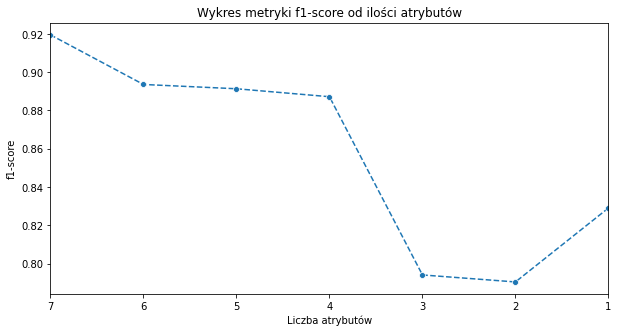

In [ ]:
evaluate_models(features_morris, mlp_models, mlp_params, amounts=10)

Sobol

In [ ]:
features_sobol = []
for g_class in range(Y.shape[1]):
  features_sobol.append(sobol.analyze(problem, Y[:, g_class])['S1'] )

features_sobol = np.array(features_sobol)
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)

                    waga
compactness     0.038013
asymmetry_coef  0.098422
k_length        0.107541
perimeter       0.159973
area            0.183072
k_width         0.227512
g_length        0.227561


Text(0.5, 0, 'numer atrybutu')

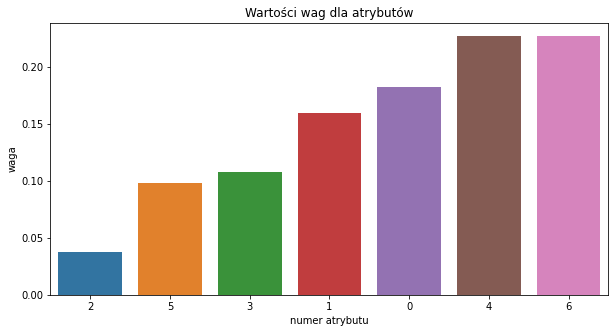

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 8ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 4ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 8ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 9ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 9ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 9ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 5ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 4ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 6ms/step


Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


2/2 [==============================] - 0s 3ms/step
########## AVG SCORES ########
ilość atrybutów: 7
                  0         1         2  micro avg  macro avg  samples avg
precision  0.964592  0.834066  0.917826   0.915771   0.905494     0.914286
recall     0.823077  1.000000  0.969231   0.914286   0.930769     0.914286
f1-score   0.887614  0.909333  0.942321   0.915022   0.913090     0.914286

ilość atrybutów: 6
                  0         1         2  micro avg  macro avg  samples avg
precision  0.873351  0.735421  0.838434   0.826856   0.815735     0.825397
recall     0.742308  0.900000  0.876923   0.825397   0.839744     0.825397
f1-score   0.801247  0.807949  0.856941   0.826121   0.822046     0.825397

ilość atrybutów: 5
                  0         1         2  micro avg  macro avg  samples avg
precision  0.970609  0.908100  0.895903    0.92381   0.924871      0.92381
recall     0.842308  0.972727  0.984615    0.92381   0.933217      0.92381
f1-score   0.901292  0.938702  0.9

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


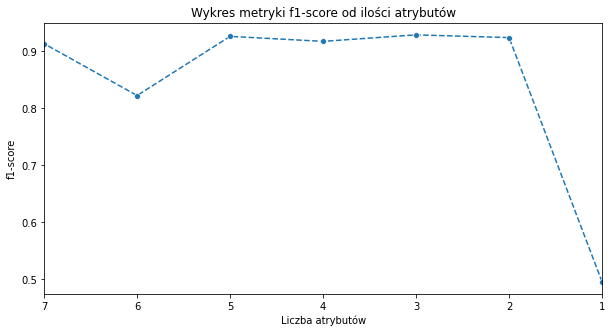

In [ ]:
evaluate_models(features_sobol, mlp_models, mlp_params, amounts=10)

# 4. SVM analiza istotności

Shap

In [ ]:
svm_model = pickle.load( open('/content/drive/MyDrive/Colab Notebooks/models/SeedModels/QMNIST_DTREE.sav', 'rb') )

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassif

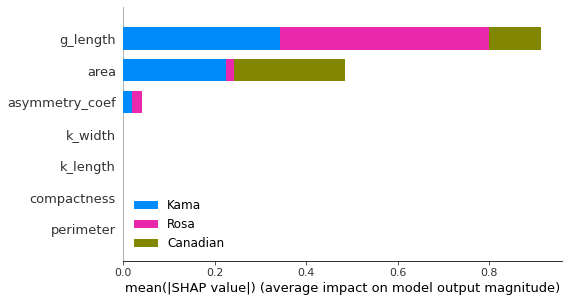

In [ ]:
svm_shap_values = shap.KernelExplainer(svm_model.predict_proba, Ksamples).shap_values(Ksamples)
shap.summary_plot(svm_shap_values, Ksamples, feature_names=x_columns, class_names=class_names)

In [ ]:
vals = np.array(svm_shap_values)
vals = np.abs(vals).sum(axis=1).mean(0)
x_columns = x_train.columns.values

features_shap = pd.DataFrame( list(zip(x_columns, vals)), columns=['name', 'waga'] )
features_shap.sort_values('waga', inplace=True, ascending=True)
features_shap.set_index('name', inplace=True)
print( features_shap )

                     waga
name                     
perimeter        0.000000
compactness      0.000000
k_length         0.000000
k_width          0.000000
asymmetry_coef   1.386667
area            16.127799
g_length        30.408952


Text(0.5, 0, 'numer atrybutu')

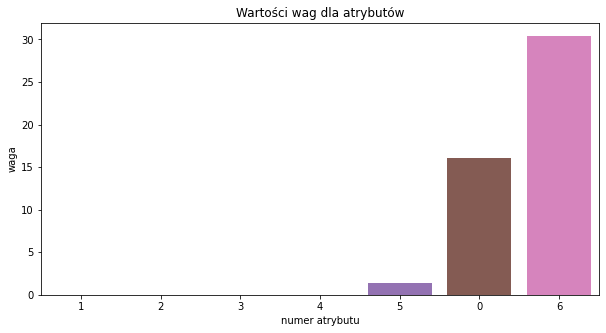

In [ ]:
x_nums = [ attributes_dict[col] for col in features_shap.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_shap, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  0.961538  1.0  0.961538  0.968254   0.974359
recall     0.961538  1.0  0.961538  0.968254   0.974359
f1-score   0.961538  1.0  0.961538  0.968254   0.974359

ilość atrybutów: 6
                  1    2         3  accuracy  macro avg
precision  0.960000  1.0  0.925926  0.952381   0.961975
recall     0.923077  1.0  0.961538  0.952381   0.961538
f1-score   0.941176  1.0  0.943396  0.952381   0.961524

ilość atrybutów: 5
                  1         2         3  accuracy  macro avg
precision  0.954545  0.846154  0.892857  0.904762   0.897852
recall     0.807692  1.000000  0.961538  0.904762   0.923077
f1-score   0.875000  0.916667  0.925926  0.904762   0.905864

ilość atrybutów: 4
                  1         2         3  accuracy  macro avg
precision  0.954545  0.733333  0.961538  0.904762   0.883139
recall     0.807692  1.000000  0.961538  0.904762   0.923077
f1-score   0.87

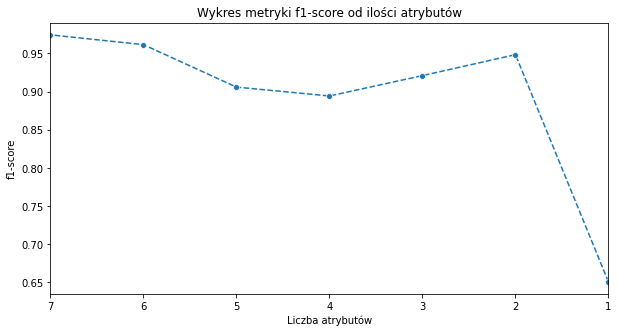

In [ ]:
svm_models = [ x for x in range( len(features_shap) ) ]
evaluate_models(features_shap, svm_models, model_builder=svm_builder(), amounts=1)

Morris

In [ ]:
X = pd.DataFrame(param_values, columns=x_train.columns)
Y = svm_model.predict_proba(X)

In [ ]:
features_morris = get_morris_features(X.values, Y, problem)
print( features_morris )

(7,)
                    waga
area            0.893759
perimeter       1.001177
compactness     1.001177
k_length        1.001177
k_width         1.001177
asymmetry_coef  1.014952
g_length        1.391485


Text(0.5, 0, 'numer atrybutu')

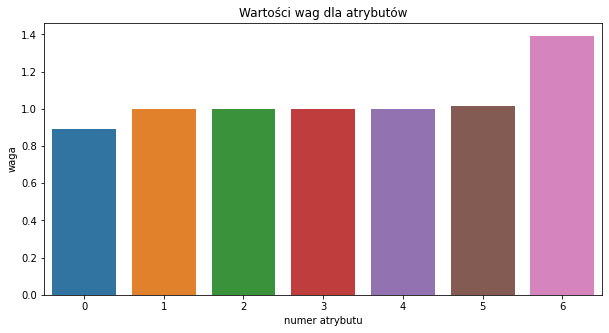

In [ ]:
x_nums = [ attributes_dict[col] for col in features_morris.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_morris, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  0.961538  1.0  0.961538  0.968254   0.974359
recall     0.961538  1.0  0.961538  0.968254   0.974359
f1-score   0.961538  1.0  0.961538  0.968254   0.974359

ilość atrybutów: 6
                  1    2         3  accuracy  macro avg
precision  0.961538  1.0  0.961538  0.968254   0.974359
recall     0.961538  1.0  0.961538  0.968254   0.974359
f1-score   0.961538  1.0  0.961538  0.968254   0.974359

ilość atrybutów: 5
                  1    2         3  accuracy  macro avg
precision  0.960000  1.0  0.925926  0.952381   0.961975
recall     0.923077  1.0  0.961538  0.952381   0.961538
f1-score   0.941176  1.0  0.943396  0.952381   0.961524

ilość atrybutów: 4
                  1         2         3  accuracy  macro avg
precision  0.954545  0.846154  0.892857  0.904762   0.897852
recall     0.807692  1.000000  0.961538  0.904762   0.923077
f1-score   0.875000  0.916667  0.92

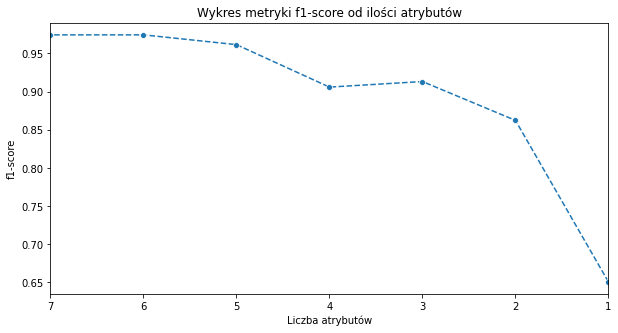

In [ ]:
evaluate_models(features_morris, svm_models, model_builder=svm_builder(), amounts=10)

Sobol

In [ ]:
features_sobol = []
for g_class in range(Y.shape[1]):
  features_sobol.append(sobol.analyze(problem, Y[:, g_class])['S1'] )

features_sobol = np.abs(np.array(features_sobol))
features_sobol = np.max(features_sobol, axis=0)

features_sobol = pd.DataFrame( features_sobol, columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)

                    waga
perimeter       0.000000
compactness     0.000000
k_length        0.000000
k_width         0.000000
asymmetry_coef  0.010942
area            0.426288
g_length        0.981917


Text(0.5, 0, 'numer atrybutu')

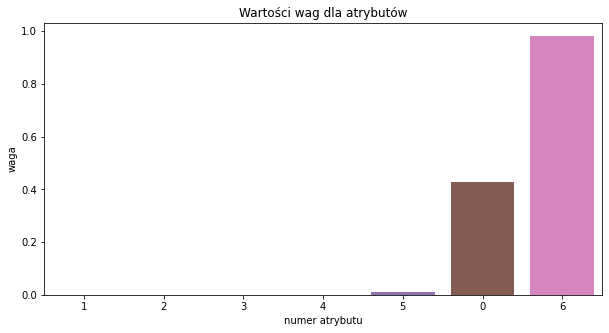

In [ ]:
x_nums = [ attributes_dict[col] for col in features_sobol.index ]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=features_sobol, x=x_nums, y='waga')
ax.set_title('Wartości wag dla atrybutów')
ax.set_xlabel('numer atrybutu')

########## AVG SCORES ########
ilość atrybutów: 7
                  1    2         3  accuracy  macro avg
precision  0.961538  1.0  0.961538  0.968254   0.974359
recall     0.961538  1.0  0.961538  0.968254   0.974359
f1-score   0.961538  1.0  0.961538  0.968254   0.974359

ilość atrybutów: 6
                  1    2         3  accuracy  macro avg
precision  0.960000  1.0  0.925926  0.952381   0.961975
recall     0.923077  1.0  0.961538  0.952381   0.961538
f1-score   0.941176  1.0  0.943396  0.952381   0.961524

ilość atrybutów: 5
                  1         2         3  accuracy  macro avg
precision  0.954545  0.846154  0.892857  0.904762   0.897852
recall     0.807692  1.000000  0.961538  0.904762   0.923077
f1-score   0.875000  0.916667  0.925926  0.904762   0.905864

ilość atrybutów: 4
                  1         2         3  accuracy  macro avg
precision  0.954545  0.733333  0.961538  0.904762   0.883139
recall     0.807692  1.000000  0.961538  0.904762   0.923077
f1-score   0.87

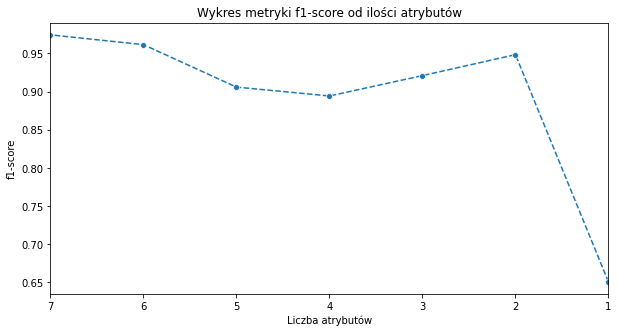

In [ ]:
evaluate_models(features_sobol, svm_models, model_builder=svm_builder(), amounts=10)